In [1]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ants

import sys
import json
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
from statsmodels.stats.oneway import anova_oneway
from scipy.ndimage import center_of_mass, label, map_coordinates
from matplotlib import cm
from matplotlib.colors import Normalize
from dataframe_help import add_temperature_w0_sw

from ghost.phantom import Caliber137

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('../data/distortions_df.csv', low_memory=False)
df = df[df['Method']=='UNetAxis']
df.drop(df[(df['Subject'] == 'P0020') & (df['Session'] == '20240419161029')].index, inplace=True)

# Cor flip x
# Sag flip y
# Axi flip z
df.loc[df['Axis'] == 'cor', 'x_reg'] *= -1
df.loc[df['Axis'] == 'sag', 'y_reg'] *= -1

df.x_diff = df.x_ref - df.x_reg
df.y_diff = df.y_ref - df.y_reg
df.z_diff = df.z_ref - df.z_reg

df['abs_x_diff'] = df.x_diff.abs()
df['abs_y_diff'] = df.y_diff.abs()
df['abs_z_diff'] = df.z_diff.abs()

df['MagDiff'] = np.sqrt(df['x_diff']**2 + df['y_diff']**2 + df['z_diff']**2)
df['LabelValue'] = df['LabelValue'].astype(int)

In [14]:
df_scale = pd.read_csv('../data/distortions_scale_df.csv')
df_scale.S *= -1
df_scale.rxy *= -1

df_scale = df_scale[df_scale.S > 0]

df_scale = add_temperature_w0_sw(df_scale, '../data')
df = add_temperature_w0_sw(df, '../data')

Adding in temperature, w0 and SW: 100%|██████████| 10884/10884 [00:05<00:00, 1950.74it/s]


## Deviations from true positions in-plane for all orientations

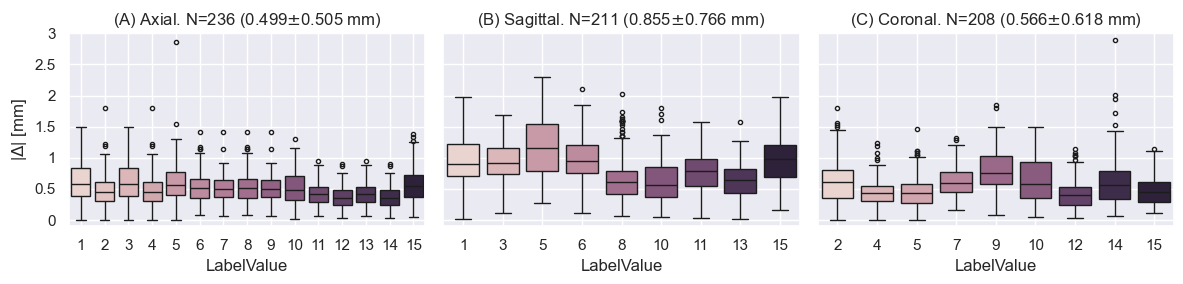

In [9]:
sns.set_theme()
fig, axes = plt.subplots(1,3,figsize=(12,3))

titles = ['(A) Axial', '(B) Sagittal', '(C) Coronal']
for i,scan_ax in enumerate(['axi', 'sag', 'cor']):
    sns.boxplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], y='MagDiff', 
                x='LabelValue',  hue='LabelValue', legend=None, ax=axes[i], flierprops={"marker": "."})

    axes[i].set_ylim([-.5,3])
    nscans = df[(df['Axis']==scan_ax) & (df['Run']==1)].Session.unique().shape[-1]
    mean_diff = df[(df['Axis']==scan_ax) & (df['Run']==1)].MagDiff.mean()
    sd_diff = df[(df['Axis']==scan_ax) & (df['Run']==1)].MagDiff.std()
    axes[i].set_title(rf"{titles[i]}. N={nscans} ({mean_diff:.3f}$\pm${1.96*sd_diff:.3f} mm)")
    # axes[i].set_xlabel(None)
    # axes[i].set_xticklabels([])

    if i>0:
        axes[i].set_ylabel(None)
        axes[i].set_yticks([0,.5,1,1.5,2,2.5,3], [])
    else:
        axes[i].set_yticks([0,.5,1,1.5,2,2.5,3], [0,.5,1,1.5,2,2.5,3])

axes[0].set_ylabel(r'|$\Delta$| [mm]')

for ax in axes:
    ax.grid('minor')
    ax.set_ylim([-.1,3])

plt.tight_layout()
plt.show()

In [10]:
# Stats on this
for i,scan_ax in enumerate(['axi', 'sag', 'cor']):
    my_data = df[(df['Axis']==scan_ax) & (df['Run']==1)]
    m = my_data.MagDiff.mean()
    s = my_data.MagDiff.std()
    print(f"{scan_ax} Mean: {m:.3} SD: {1.96*s:.3}")

axi Mean: 0.499 SD: 0.505
sag Mean: 0.855 SD: 0.766
cor Mean: 0.566 SD: 0.618


/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_94140/4284994105.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



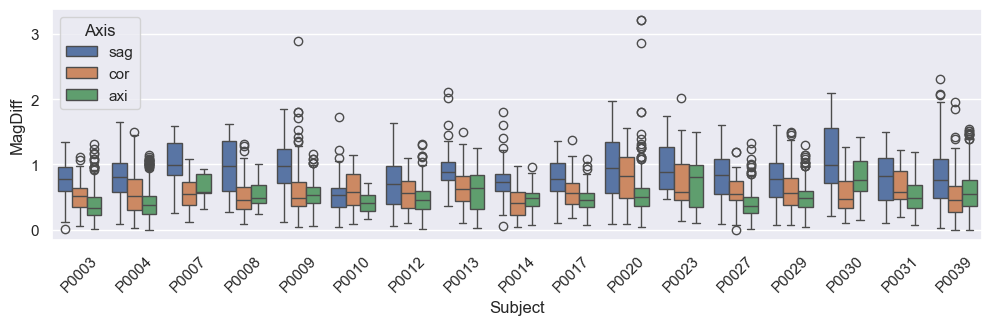

In [11]:
sns.set_theme()
# How does this differ by site?
fig, ax = plt.subplots(1,1,figsize=(12,3))
df_axi = df[df.Axis=='axi']
sns.boxplot(data=df, x='Subject', y='MagDiff', ax=ax, hue='Axis')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
plt.show()

In [13]:
df

,LabelValue,x_org,y_org,z_org,x_ref,y_ref,z_ref,x_reg,y_reg,z_reg,...,Subject,Session,Method,abs_x_diff,abs_y_diff,abs_z_diff,MagDiff,Temperature,w0,SoftwareVersions
30,1,85.000000,54.400001,-49.600001,0.0,50.0,50.0,0.000000,50.346401,49.625938,...,P0003,20230927164642,UNetAxis,0.000000,0.346401,0.374062,0.509819,23.0,2.730387,[8.6.0]
31,3,85.000000,155.200002,-51.200001,0.0,-50.0,50.0,0.000000,-50.722435,49.643654,...,P0003,20230927164642,UNetAxis,0.000000,0.722435,0.356346,0.805540,23.0,2.730387,[8.6.0]
32,5,85.000000,104.000002,-49.600001,0.0,0.0,50.0,0.000000,0.635910,50.449867,...,P0003,20230927164642,UNetAxis,0.000000,0.635910,0.449867,0.778949,23.0,2.730387,[8.6.0]
33,6,85.000000,54.400001,-97.600002,0.0,50.0,0.0,0.000000,49.017479,-0.075790,...,P0003,20230927164642,UNetAxis,0.000000,0.982521,0.075790,0.985440,23.0,2.730387,[8.6.0]
34,8,85.000000,153.600002,-99.200002,0.0,-50.0,0.0,0.000000,-50.447807,-0.084656,...,P0003,20230927164642,UNetAxis,0.000000,0.447807,0.084656,0.455739,23.0,2.730387,[8.6.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39049,11,87.393105,47.062066,-145.000000,0.0,50.0,0.0,0.107895,50.170631,0.000000,...,P0039,20240207083415,UNetAxis,0.107895,0.170631,0.000000,0.201882,24.0,2.699173,[8.6.1]
39050,12,139.200002,100.799998,-145.000000,-50.0,0.0,0.0,-50.338173,-0.121452,0.000000,...,P0039,20240207083415,UNetAxis,0.338173,0.121452,0.000000,0.359321,24.0,2.699173,[8.6.1]
39051,13,88.000001,151.999999,-145.000000,0.0,-50.0,0.0,0.107895,-49.829178,0.000000,...,P0039,20240207083415,UNetAxis,0.107895,0.170822,0.000000,0.202043,24.0,2.699173,[8.6.1]
39052,14,37.107693,98.892306,-145.000000,50.0,0.0,0.0,49.661606,-0.121445,0.000000,...,P0039,20240207083415,UNetAxis,0.338394,0.121445,0.000000,0.359527,24.0,2.699173,[8.6.1]


/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_94140/1620126051.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



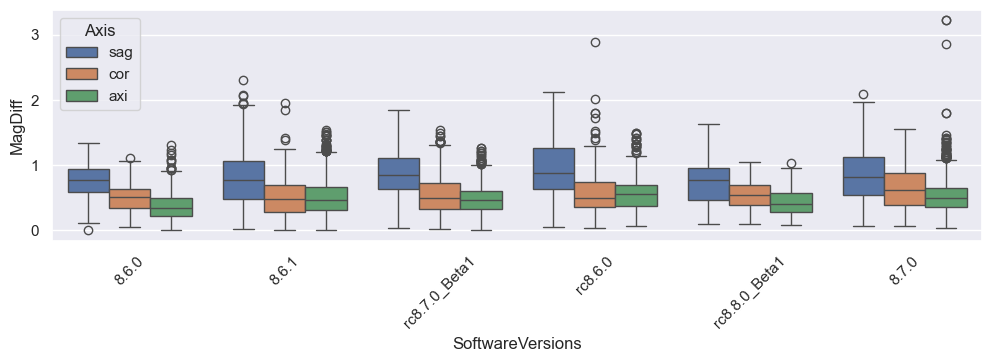

In [15]:
sns.set_theme()
# How does this differ by SW
fig, ax = plt.subplots(1,1,figsize=(12,3))

sns.boxplot(data=df, x='SoftwareVersions', y='MagDiff', ax=ax, hue='Axis')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
plt.show()

In [17]:
my_df = df.copy()

formula = 'MagDiff ~ C(Axis) + C(SoftwareVersions) + C(Subject)'
model = smf.ols(formula, data=my_df).fit()

anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

                         sum_sq       df            F    PR(>F)
C(Axis)              182.624269      2.0  1144.349226  0.000000
C(SoftwareVersions)    0.552984      5.0     1.386031  0.239102
C(Subject)             1.769549     16.0     1.386031  0.239102
Residual             866.641993  10861.0          NaN       NaN


/Users/emil/miniforge3/envs/rrdf2/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1

/Users/emil/miniforge3/envs/rrdf2/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 16, but rank is 1



## Scale and sheer

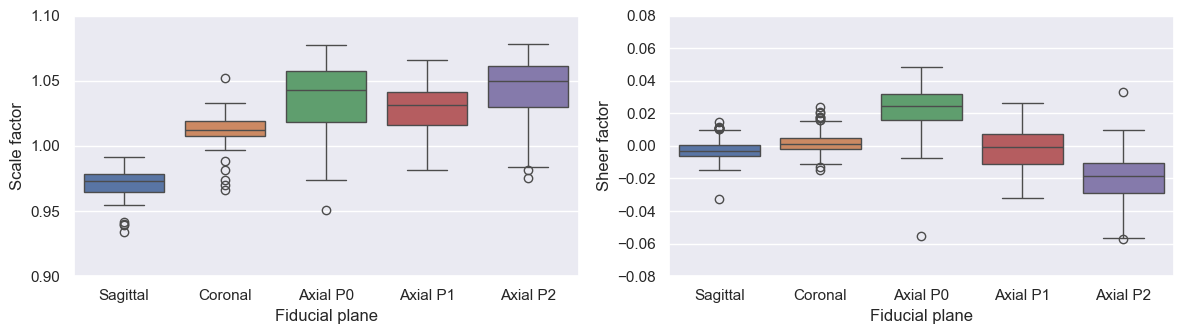

In [18]:
df_scale['new_axis'] = df_scale['Axis'].astype(str) + df_scale['Plate'].astype(str)
df_scale['nice_axis'] = ''
df_scale.loc[df_scale['new_axis']=='axi0', 'nice_axis'] = 'Axial P0'
df_scale.loc[df_scale['new_axis']=='axi1', 'nice_axis'] = 'Axial P1'
df_scale.loc[df_scale['new_axis']=='axi2', 'nice_axis'] = 'Axial P2'
df_scale.loc[df_scale['new_axis']=='sag0', 'nice_axis'] = 'Sagittal'
df_scale.loc[df_scale['new_axis']=='cor0', 'nice_axis'] = 'Coronal'

sw_order = ['rc8.6.0', '8.6.0', '8.6.1', 'rc8.7.0_Beta1', '8.7.0', 'rc8.8.0_Beta1']

gs = gridspec.GridSpec(1,2, width_ratios=[1,1])
fig = plt.figure(figsize=(12,3.5))

ax = fig.add_subplot(gs[0,0])
sns.boxplot(df_scale, y='S', x='nice_axis', hue='new_axis', ax=ax, legend=None)
ax.set_ylim([0.9, 1.1])
ax.set_ylabel('Scale factor')
ax.set_xlabel('Fiducial plane')

ax = fig.add_subplot(gs[0,1])
sns.boxplot(df_scale, y='rxy', x='nice_axis', hue='new_axis', ax=ax, legend=None)
ax.set_ylim([-.08, .08])
ax.set_ylabel('Sheer factor')
ax.set_xlabel('Fiducial plane')

plt.tight_layout()
plt.show()

In [19]:
# Look at sheering and if different from 0
# Coronal 
data = df_scale[df_scale.Axis=='cor'].rxy
print(f"Coronal - Mean={data.mean():.5f} CI={np.array([-1,1])*1.96*data.std() + data.mean()}")

data = df_scale[df_scale.Axis=='sag'].rxy
print(f"Sag - Mean={data.mean():.5f} CI={np.array([-1,1])*1.96*data.std() + data.mean()}")

data = df_scale[(df_scale.Axis=='axi') & (df_scale.Plate==1)].rxy
print(f"Axial P1 - Mean={data.mean():.5f} CI={np.array([-1,1])*1.96*data.std() + data.mean()}")

Coronal - Mean=0.00185 CI=[-0.01063814  0.01434289]
Sag - Mean=-0.00283 CI=[-0.0146205   0.00896915]
Axial P1 - Mean=-0.00185 CI=[-0.02472691  0.02102967]


In [20]:
# Check anova
anova_data = df_scale['S']
groups = df_scale['Axis']
res = anova_oneway(anova_data, groups)
print(f"ANOVA p-value for difference between axes: {res.pvalue}")

new_df = df_scale[df_scale.Axis=='axi']
anova_data = new_df['S']
groups = new_df['Plate']
res = anova_oneway(anova_data, groups)
print(f"ANOVA p-value for difference between plates on axial: {res.pvalue}")

ANOVA p-value for difference between axes: 3.7401534285761705e-280
ANOVA p-value for difference between plates on axial: 2.4034785362810233e-28


In [29]:
for k in ['S', 'rxy']:
    print(f"----------- {k} axi -----------")
    my_df = df_scale[df_scale.Axis=='axi'].copy()

    formula = f'{k} ~ C(Plate) + C(SoftwareVersions) + C(Subject)'
    model = smf.ols(formula, data=my_df).fit()

    anova_results = sm.stats.anova_lm(model, typ=2)

    print(anova_results)

----------- S axi -----------
                       sum_sq      df           F         PR(>F)
C(Plate)             0.049289     2.0  314.766391  1.707987e-113
C(SoftwareVersions)  0.185679     5.0  474.309463  1.893046e-297
C(Subject)           0.046697    16.0   37.276945   6.082563e-96
Residual             0.108908  1391.0         NaN            NaN
----------- rxy axi -----------
                       sum_sq      df            F        PR(>F)
C(Plate)             0.429660     2.0  1655.422676  0.000000e+00
C(SoftwareVersions)  0.006638     5.0    10.229806  1.211611e-09
C(Subject)           0.012708    16.0     6.120050  2.845617e-13
Residual             0.180515  1391.0          NaN           NaN


In [30]:
for ax in ['sag', 'cor']:
    for k in ['S', 'rxy']:
        print(f"----------- {k} {ax} -----------")
        my_df = df_scale[df_scale.Axis=='sag'].copy()

        formula = f'{k} ~ C(SoftwareVersions) + C(Subject)'
        model = smf.ols(formula, data=my_df).fit()

        anova_results = sm.stats.anova_lm(model, typ=2)

        print(anova_results)

----------- S sag -----------
                       sum_sq     df          F        PR(>F)
C(SoftwareVersions)  0.005546    5.0  57.202942  3.673027e-36
C(Subject)           0.010805   16.0  34.826923  5.819636e-48
Residual             0.003703  191.0        NaN           NaN
----------- rxy sag -----------
                       sum_sq     df         F        PR(>F)
C(SoftwareVersions)  0.000821    5.0  8.230815  4.632034e-07
C(Subject)           0.002380   16.0  7.457148  1.995634e-13
Residual             0.003810  191.0       NaN           NaN
----------- S cor -----------
                       sum_sq     df          F        PR(>F)
C(SoftwareVersions)  0.005546    5.0  57.202942  3.673027e-36
C(Subject)           0.010805   16.0  34.826923  5.819636e-48
Residual             0.003703  191.0        NaN           NaN
----------- rxy cor -----------
                       sum_sq     df         F        PR(>F)
C(SoftwareVersions)  0.000821    5.0  8.230815  4.632034e-07
C(Subject)    

In [66]:
# Plot distortions
phantom = Caliber137()
base_img = ants.image_read(phantom.get_phantom_nii(weighting='T2w'))
fiducials = ants.image_read(phantom.get_seg_nii('fiducials')).numpy()
affine = base_img.to_nibabel().affine

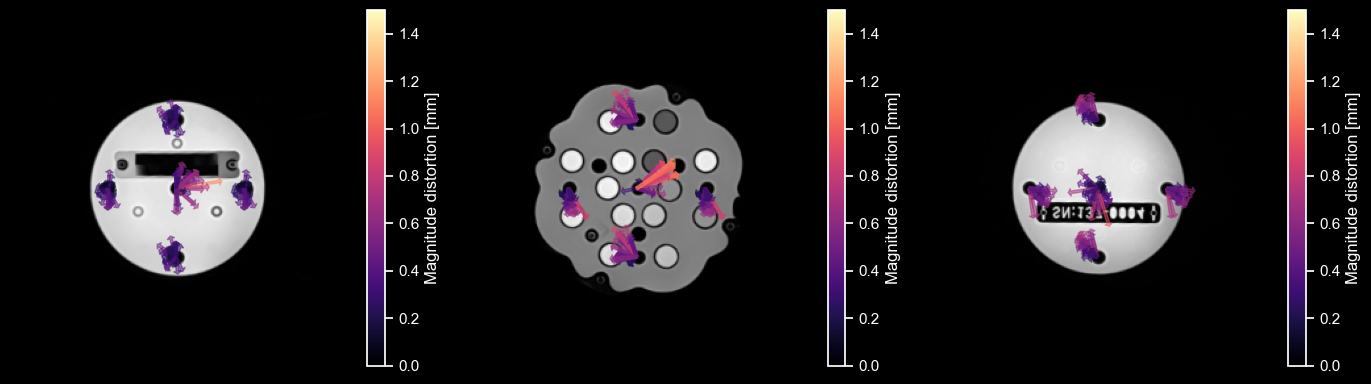

In [75]:
# Setup base figure
plt.style.use('dark_background')
fig, axes = plt.subplots(1,3, figsize=(14,4))
cog = [int(x) for x in center_of_mass(fiducials==1)]
axes[0].imshow(base_img[:,:,cog[2]], cmap='gray')

cog = [int(x) for x in center_of_mass(fiducials==6)]
axes[1].imshow(base_img[:,:,cog[2]], cmap='gray')

cog = [int(x) for x in center_of_mass(fiducials==11)]
axes[2].imshow(base_img[:,:,cog[2]], cmap='gray')

norm = Normalize(vmin=0, vmax=1.5)
sm = cm.ScalarMappable(cmap=cm.magma, norm=norm)

df_axi = df[(df.Axis == 'axi') & (df.Subject=='P0004')]

for sub in df_axi.Subject.unique():
    for i,row in df_axi[df_axi.Subject == sub].iterrows():
        if row.LabelValue < 6:
            ax = axes[0]
        elif row.LabelValue < 11:
            ax = axes[1]
        else:
            ax = axes[2]
        
        cog = [int(x) for x in center_of_mass(fiducials==row.LabelValue)]
        mag = np.sqrt(row.x_diff**2 + row.y_diff**2)
        ax.arrow(cog[1], cog[0], row.y_diff*30, row.x_diff*30, width=2, head_length=2, color=sm.to_rgba(mag), alpha=0.5, linewidth=None)

for ax in axes:
    ax.axis('off')
    plt.colorbar(sm, ax=ax, label='Magnitude distortion [mm]')

plt.tight_layout()
# plt.savefig('../figures/ghost_distortion_arrows_all.png', dpi=300)

plt.show()

In [57]:
# Check anova
new_df = pd.concat([df_scale[(df_scale.Axis=='axi') & (df_scale.Plate==1)], df_scale[df_scale.Axis.isin(['sag', 'cor'])]])
anova_data = new_df['rxy']
groups = new_df['Axis']
res = anova_oneway(anova_data, groups)
print(f"ANOVA p-value for difference between axes: {res.pvalue}")

# new_df = df_scale[df_scale.Axis=='axi']
# anova_data = new_df['rxy']
# groups = new_df['Plate']
# res = anova_oneway(anova_data, groups)
# print(f"ANOVA p-value for difference between plates on axial: {res.pvalue}")

ANOVA p-value for difference between axes: 8.331836761403267e-14


/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_48342/3745358448.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i,0].set_xticklabels(labels=axes[i,0].get_xticklabels(), rotation=90)
/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_48342/3745358448.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i,1].set_xticklabels(labels=axes[i,1].get_xticklabels(), rotation=45)
/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_48342/3745358448.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i,0].set_xticklabels(labels=axes[i,0].get_xticklabels(), rotation=90)
/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_48342/3745358448.py:14: UserWarning: set_ticklabels() should only be used wit

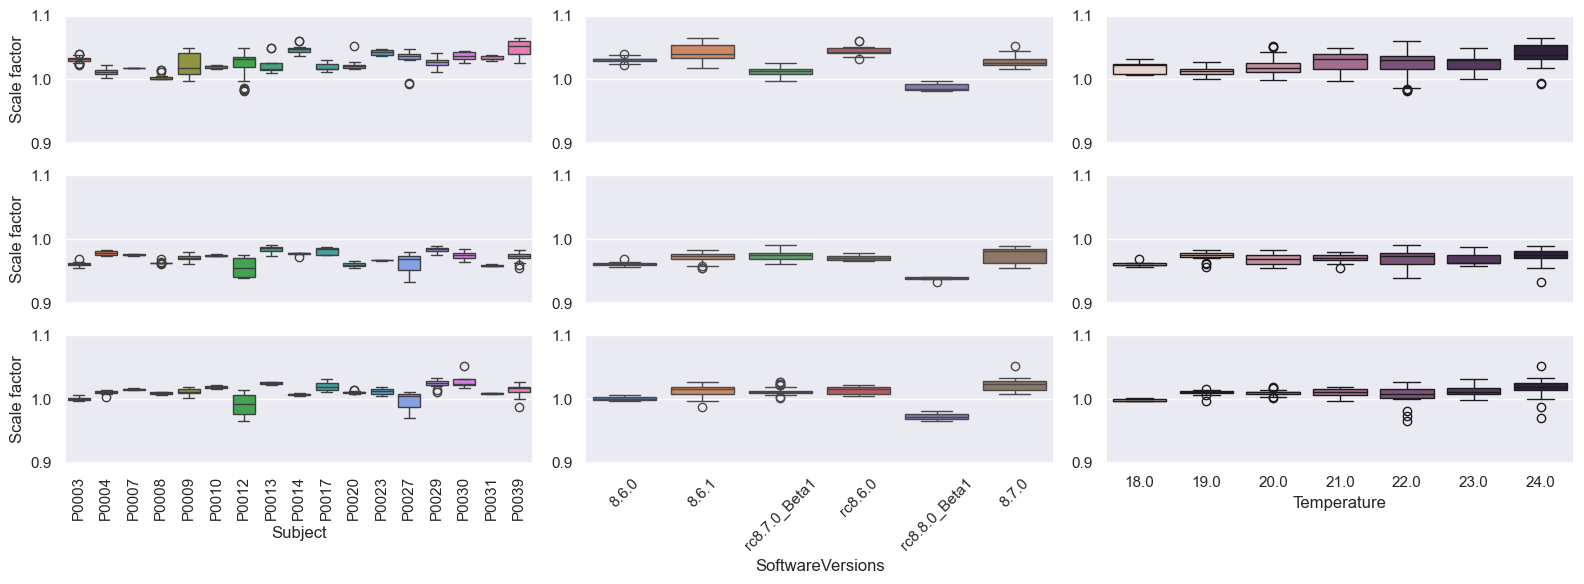

In [34]:
fig, axes = plt.subplots(3,3, figsize=(16,6))

for i,scan_ax in enumerate(['axi', 'sag', 'cor']):
    plate = 1 if scan_ax=='axi' else 0
    my_filt = (df_scale.Axis==scan_ax) & (df_scale.Plate==plate)
    sns.boxplot(df_scale[my_filt], y='S', x='Subject', hue='Subject', ax=axes[i,0], legend=None)
    sns.boxplot(df_scale[my_filt], y='S', x='SoftwareVersions', hue='SoftwareVersions', ax=axes[i,1], legend=False)
    sns.boxplot(df_scale[my_filt], y='S', x='Temperature', hue='Temperature', ax=axes[i,2], legend=None)

    axes[i,1].set_ylabel(None)
    axes[i,2].set_ylabel(None)

    axes[i,0].set_xticklabels(labels=axes[i,0].get_xticklabels(), rotation=90)
    axes[i,1].set_xticklabels(labels=axes[i,1].get_xticklabels(), rotation=45)

    for ax in axes[i,:]:
        # ax.hlines(1, ax.get_xlim()[0], ax.get_xlim()[1], color='k', linestyles='-', alpha=0.5)
        ax.set_ylim([.9, 1.1])

        if i<2:
            ax.set_xlabel(None)
            ax.set_xticklabels([])

    axes[i,0].set_ylabel('Scale factor')

plt.tight_layout()
plt.show()

/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_55415/2506301924.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i,0].set_xticklabels(labels=axes[i,0].get_xticklabels(), rotation=90)
/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_55415/2506301924.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i,1].set_xticklabels(labels=axes[i,1].get_xticklabels(), rotation=45)
/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_55415/2506301924.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i,0].set_xticklabels(labels=axes[i,0].get_xticklabels(), rotation=90)
/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_55415/2506301924.py:12: UserWarning: set_ticklabels() should only be used wit

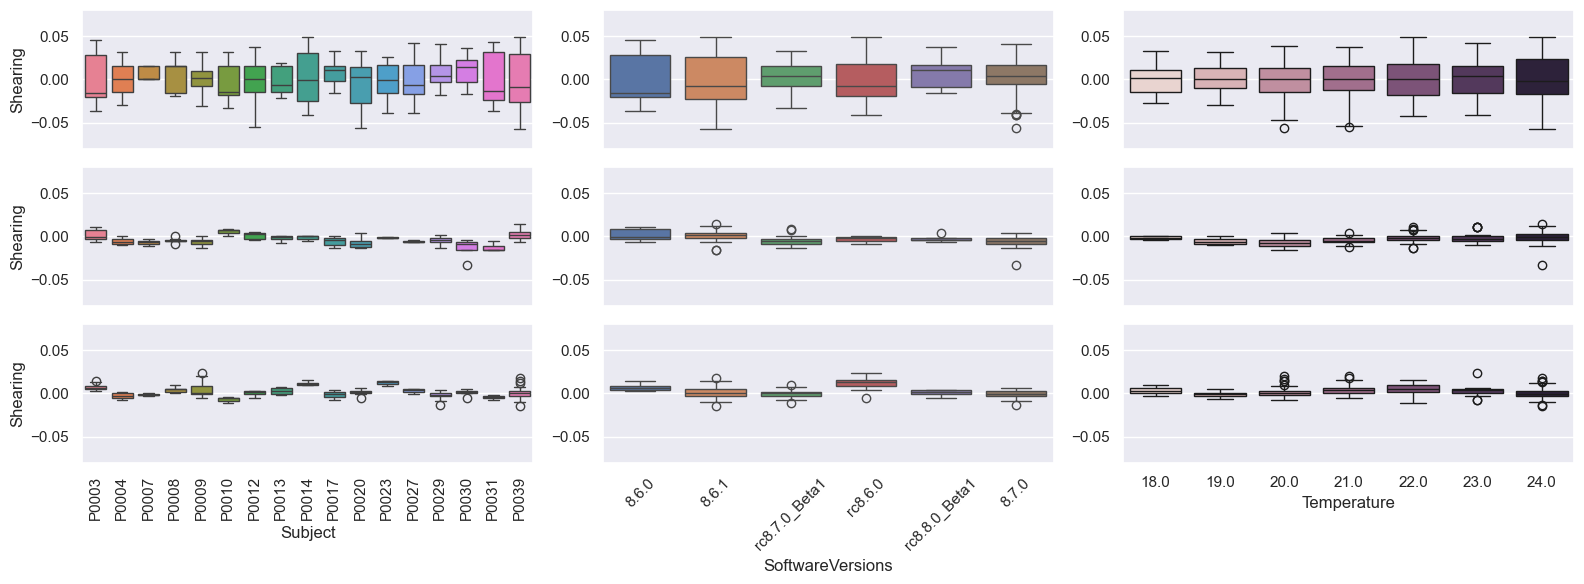

In [166]:
fig, axes = plt.subplots(3,3, figsize=(16,6))

for i,scan_ax in enumerate(['axi', 'sag', 'cor']):
    sns.boxplot(df_scale[df_scale.Axis==scan_ax], y='rxy', x='Subject', hue='Subject', ax=axes[i,0], legend=None)
    sns.boxplot(df_scale[df_scale.Axis==scan_ax], y='rxy', x='SoftwareVersions', hue='SoftwareVersions', ax=axes[i,1], legend=False)
    sns.boxplot(df_scale[df_scale.Axis==scan_ax], y='rxy', x='Temperature', hue='Temperature', ax=axes[i,2], legend=None)

    axes[i,1].set_ylabel(None)
    axes[i,2].set_ylabel(None)

    axes[i,0].set_xticklabels(labels=axes[i,0].get_xticklabels(), rotation=90)
    axes[i,1].set_xticklabels(labels=axes[i,1].get_xticklabels(), rotation=45)

    for ax in axes[i,:]:
        # ax.hlines(1, ax.get_xlim()[0], ax.get_xlim()[1], color='k', linestyles='-', alpha=0.5)
        ax.set_ylim([-.08, .08])

        if i<2:
            ax.set_xlabel(None)
            ax.set_xticklabels([])

    axes[i,0].set_ylabel('Shearing')

plt.tight_layout()
plt.show()

/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_55415/3613126755.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_55415/3613126755.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)


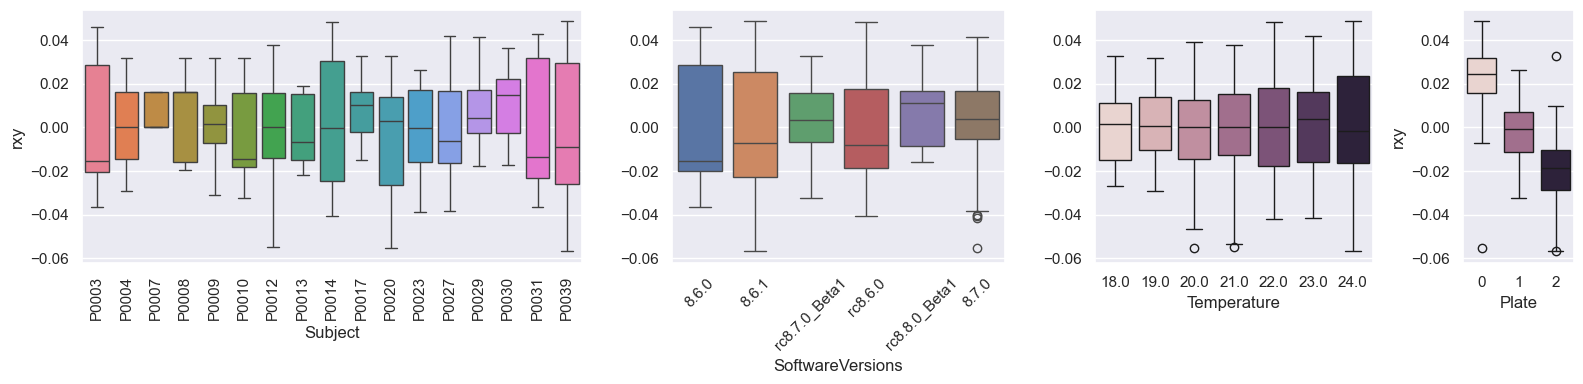

In [180]:
gs = gridspec.GridSpec(1,4,width_ratios=[18,12,10,4])
fig = plt.figure(figsize=(16,4))

axes = []
for i in range(4):
    ax = fig.add_subplot(gs[i])
    axes.append(ax)

sns.boxplot(df_scale[df_scale.Axis=='axi'], y='rxy', x='Subject', hue='Subject', ax=axes[0], legend=None)
sns.boxplot(df_scale[df_scale.Axis=='axi'], y='rxy', x='SoftwareVersions', hue='SoftwareVersions', ax=axes[1], legend=False)
sns.boxplot(df_scale[df_scale.Axis=='axi'], y='rxy', x='Temperature', hue='Temperature', ax=axes[2], legend=None)
sns.boxplot(df_scale[df_scale.Axis=='axi'], y='rxy', x='Plate', hue='Plate', ax=axes[3], legend=None)

axes[1].set_ylabel(None)
axes[2].set_ylabel(None)

axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)

# for ax in axes:
    # ax.hlines(1, ax.get_xlim()[0], ax.get_xlim()[1], color='k', linestyles='-', alpha=0.5)
    # ax.set_ylim([.95, 1.1])

# axes[0].set_ylabel('Scale factor')
plt.tight_layout()
plt.show()

/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_55415/858921995.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_55415/858921995.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)


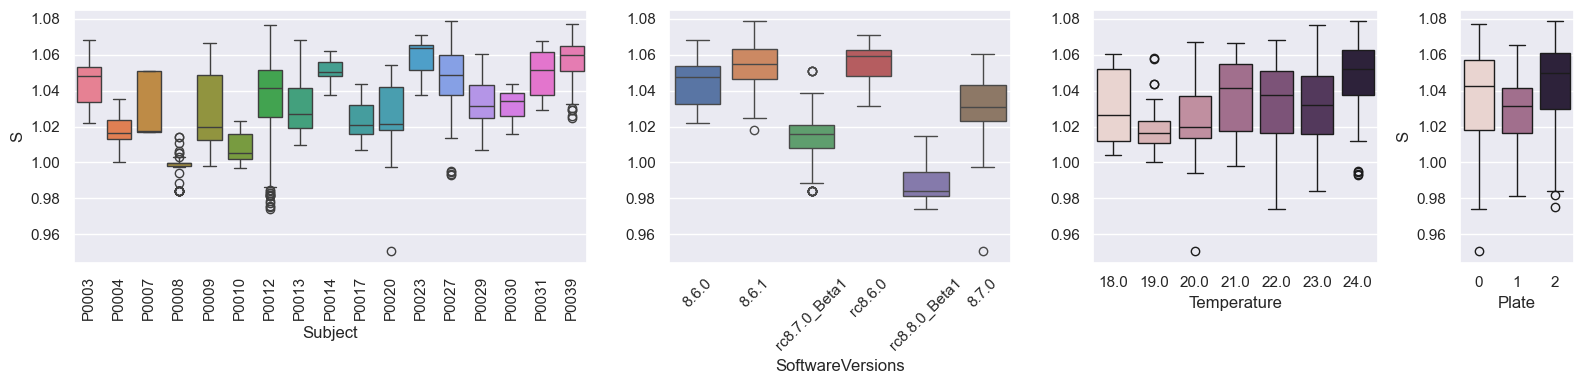

In [181]:
gs = gridspec.GridSpec(1,4,width_ratios=[18,12,10,4])
fig = plt.figure(figsize=(16,4))

axes = []
for i in range(4):
    ax = fig.add_subplot(gs[i])
    axes.append(ax)

sns.boxplot(df_scale[df_scale.Axis=='axi'], y='S', x='Subject', hue='Subject', ax=axes[0], legend=None)
sns.boxplot(df_scale[df_scale.Axis=='axi'], y='S', x='SoftwareVersions', hue='SoftwareVersions', ax=axes[1], legend=False)
sns.boxplot(df_scale[df_scale.Axis=='axi'], y='S', x='Temperature', hue='Temperature', ax=axes[2], legend=None)
sns.boxplot(df_scale[df_scale.Axis=='axi'], y='S', x='Plate', hue='Plate', ax=axes[3], legend=None)

axes[1].set_ylabel(None)
axes[2].set_ylabel(None)

axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)

# for ax in axes:
    # ax.hlines(1, ax.get_xlim()[0], ax.get_xlim()[1], color='k', linestyles='-', alpha=0.5)
    # ax.set_ylim([.95, 1.1])

# axes[0].set_ylabel('Scale factor')
plt.tight_layout()
plt.show()

/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_26889/1525819986.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_26889/1525819986.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)


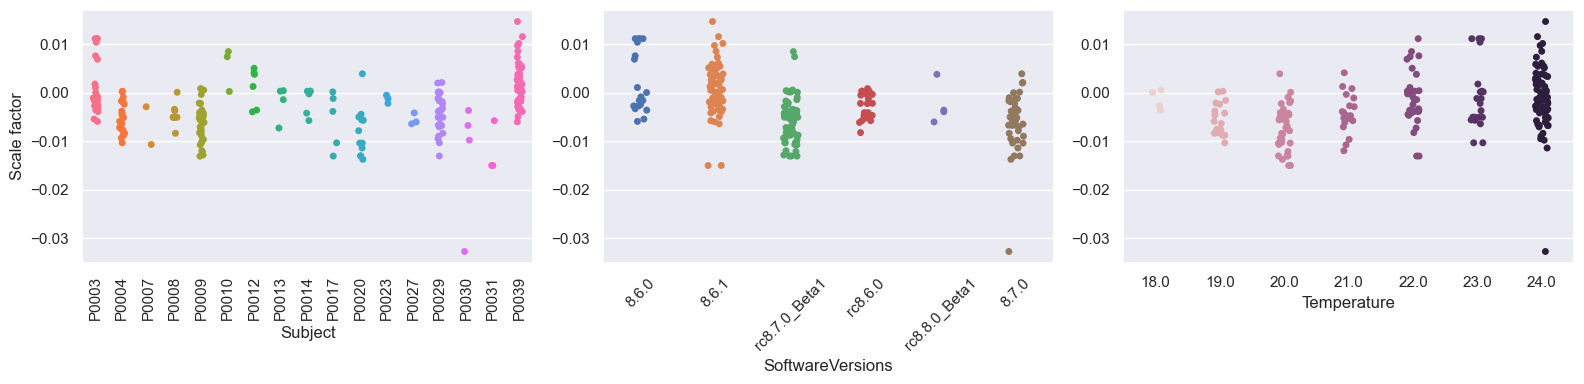

In [142]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
sns.stripplot(df_scale[df_scale.Axis=='sag'], y='rxy', x='Subject', hue='Subject', ax=axes[0], legend=None)
sns.stripplot(df_scale[df_scale.Axis=='sag'], y='rxy', x='SoftwareVersions', hue='SoftwareVersions', ax=axes[1], legend=False)
sns.stripplot(df_scale[df_scale.Axis=='sag'], y='rxy', x='Temperature', hue='Temperature', ax=axes[2], legend=None)

axes[1].set_ylabel(None)
axes[2].set_ylabel(None)

axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)

# for ax in axes:
    # ax.hlines(1, ax.get_xlim()[0], ax.get_xlim()[1], color='k', linestyles='-', alpha=0.5)
    # ax.set_ylim([.95, 1.1])

axes[0].set_ylabel('Scale factor')
plt.tight_layout()
plt.show()

/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_26889/844878608.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_26889/844878608.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)


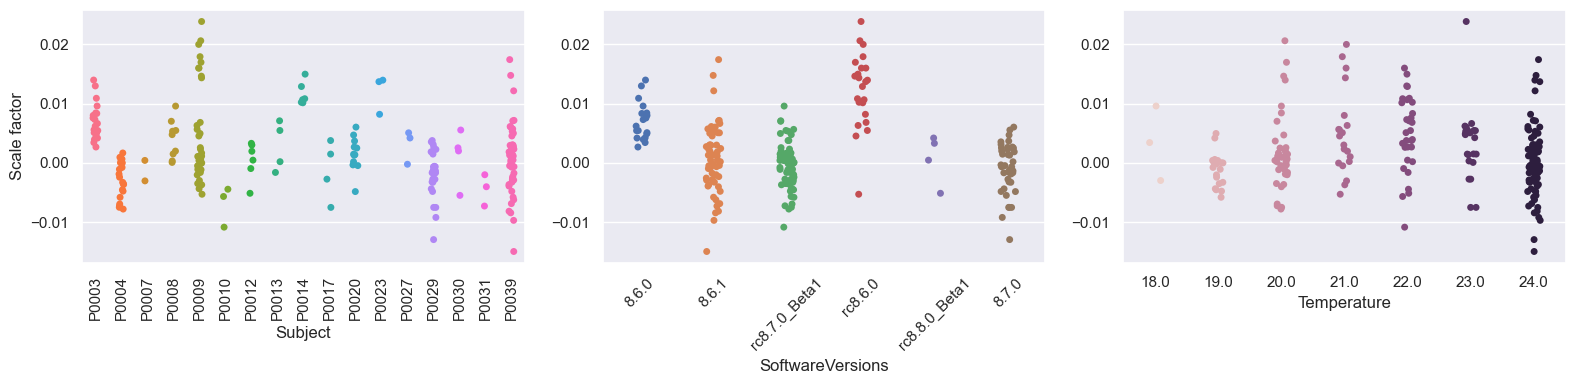

In [143]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
sns.stripplot(df_scale[df_scale.Axis=='cor'], y='rxy', x='Subject', hue='Subject', ax=axes[0], legend=None)
sns.stripplot(df_scale[df_scale.Axis=='cor'], y='rxy', x='SoftwareVersions', hue='SoftwareVersions', ax=axes[1], legend=False)
sns.stripplot(df_scale[df_scale.Axis=='cor'], y='rxy', x='Temperature', hue='Temperature', ax=axes[2], legend=None)

axes[1].set_ylabel(None)
axes[2].set_ylabel(None)

axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)

# for ax in axes:
    # ax.hlines(1, ax.get_xlim()[0], ax.get_xlim()[1], color='k', linestyles='-', alpha=0.5)
    # ax.set_ylim([.95, 1.1])

axes[0].set_ylabel('Scale factor')
plt.tight_layout()
plt.show()

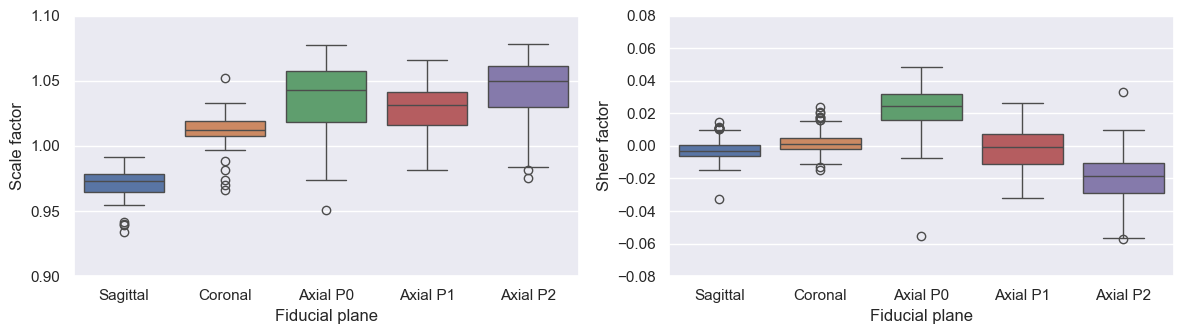

# Additional figures

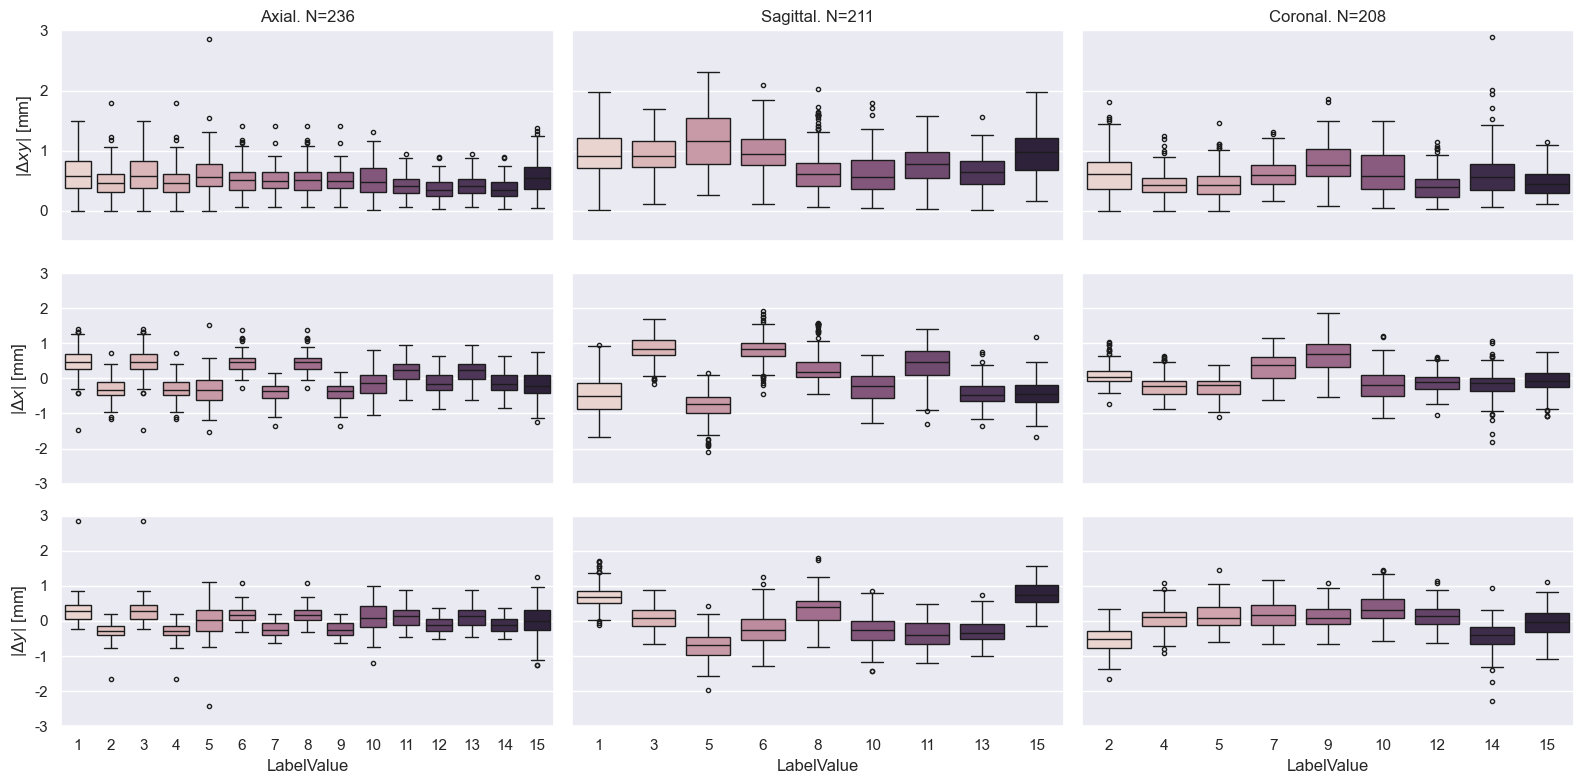

In [28]:
fig, axes = plt.subplots(3,3,figsize=(16,8))

titles = ['Axial', 'Sagittal', 'Coronal']
for i,scan_ax in enumerate(['axi', 'sag', 'cor']):
    sns.boxplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], y='MagDiff', 
                x='LabelValue',  hue='LabelValue', legend=None, ax=axes[0,i], flierprops={"marker": "."})

    axes[0,i].set_ylim([-.5,3])
    nscans = df[(df['Axis']==scan_ax) & (df['Run']==1)].Session.unique().shape[-1]
    axes[0,i].set_title(f"{titles[i]}. N={nscans}")
    axes[0,i].set_xlabel(None)
    axes[0,i].set_xticklabels([])

    if i>0:
        axes[0,i].set_ylabel(None)
        axes[0,i].set_yticks([0,1,2,3], [])
    else:
        axes[0,i].set_yticks([0,1,2,3], [0,1,2,3])

for i,scan_ax in enumerate(['axi', 'sag', 'cor']):
    
    if scan_ax == 'axi':
        y = ['x_diff', 'y_diff']
    if scan_ax == 'sag':
        y = ['y_diff', 'z_diff']
    if scan_ax == 'cor':
        y = ['x_diff', 'z_diff']
    
    for k in range(2):
        sns.boxplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], y='' + y[k], 
                    x='LabelValue',  hue='LabelValue', legend=None, ax=axes[k+1,i], flierprops={"marker": "."})
        
        axes[k+1,i].set_ylim([-3,3])

        if k==0:
            axes[k+1,i].set_xlabel(None)
            axes[k+1,i].set_xticklabels([])
        
        if i>0:
            axes[k+1,i].set_ylabel(None)
            axes[k+1,i].set_yticks([-3,-2,-1,0,1,2,3], [])
        else:
            axes[k+1,i].set_yticks([-3,-2,-1,0,1,2,3], [-3,-2,-1,0,1,2,3])
    
axes[0,0].set_ylabel(r'|$\Delta xy$| [mm]')
axes[1,0].set_ylabel(r'|$\Delta x$| [mm]')
axes[2,0].set_ylabel(r'|$\Delta y$| [mm]')
# axes[1,0].set_ylabel('Abs. y error [mm]')

plt.tight_layout()
plt.show()

/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_81051/781694654.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_81051/781694654.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)


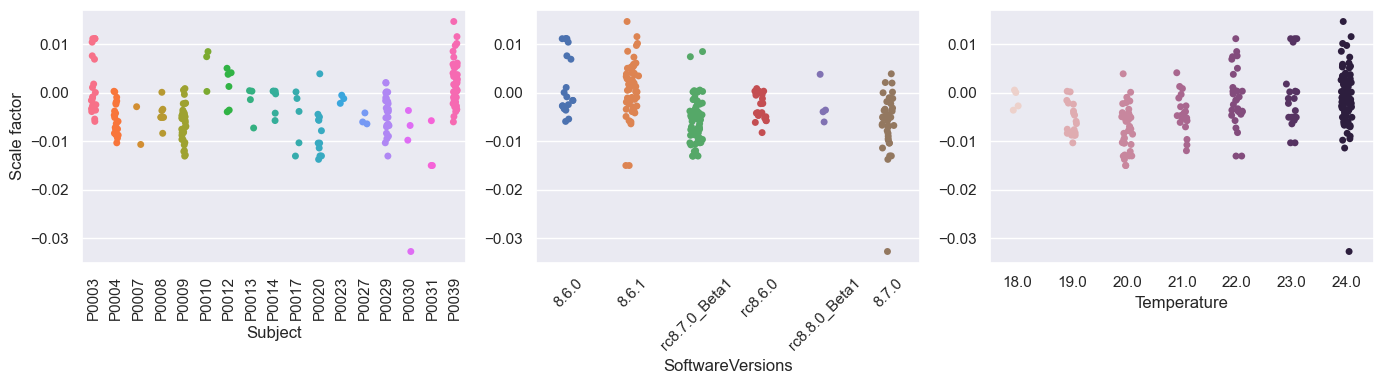

In [54]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
sns.stripplot(df_scale[df_scale.Axis=='sag'], y='rxy', x='Subject', hue='Subject', ax=axes[0], legend=None)
sns.stripplot(df_scale[df_scale.Axis=='sag'], y='rxy', x='SoftwareVersions', hue='SoftwareVersions', ax=axes[1], legend=False)
sns.stripplot(df_scale[df_scale.Axis=='sag'], y='rxy', x='Temperature', hue='Temperature', ax=axes[2], legend=None)

axes[1].set_ylabel(None)
axes[2].set_ylabel(None)

axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)

# for ax in axes:
    # ax.hlines(1, ax.get_xlim()[0], ax.get_xlim()[1], color='k', linestyles='-', alpha=0.5)
    # ax.set_ylim([.95, 1.1])


axes[0].set_ylabel('Scale factor')
plt.tight_layout()
plt.show()

In [ ]:
def make_diff_plot(df, scan_ax):

    df2 = df.copy()
    df2['LabelValue'] = df2['LabelValue'].astype('str')

    if scan_ax == 'axi':
        y = ['x_diff', 'y_diff']
    if scan_ax == 'sag':
        y = ['y_diff', 'z_diff']
    if scan_ax == 'cor':
        y = ['x_diff', 'z_diff']

    fig, axes = plt.subplots(2,1,figsize=(10,4))
    
    sns.stripplot(data=df2[(df2['Axis']==scan_ax) & (df2['Run']==1)], y=y[0], 
                x='LabelValue', ax=axes[0], hue='LabelValue', alpha=0.2, legend=None, palette='dark')
    

    sns.stripplot(data=df2[(df2['Axis']==scan_ax) & (df2['Run']==1)], y=y[1], 
                    x='LabelValue', ax=axes[1], hue='LabelValue', alpha=0.2, legend=None)


    axes[0].plot(axes[0].get_xlim(),[0,0], '-k', alpha=0.5)
    axes[1].plot(axes[1].get_xlim(),[0,0], '-k', alpha=0.5)

    axes[0].set_xlabel(None)
    axes[0].set_xticks([])

    # axes[0].axis([-0.5,14.5,-3,3])
    # axes[1].axis([-0.5,14.5,-3,3])

    axes[0].set_ylabel('X diff [mm]')
    axes[1].set_ylabel('Y diff [mm]')
    axes[1].set_xlabel('Fiducial')

    axes[0].set_yticks([-3,-2,-1,0,1,2,3])
    axes[1].set_yticks([-3,-2,-1,0,1,2,3])

    plt.tight_layout()
    plt.show()

make_diff_plot(df, scan_ax='axi')
